<a href="https://colab.research.google.com/github/shahiryar/QAOA_Maxcut_for_weighted_graphs/blob/main/Maxcut_weighted_graph_QAOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Maxcut for weighted graphs

In [137]:
import networkx as nx
from matplotlib import pyplot as plt

In [138]:
class G:
  def __init__(self, edges_set): #include weights here
    self.edges_set = edges_set
    self.node_set = []
    # for each edge get the node which are not already in the node_sets
    for i in edges_set:
      if(i.start_node not in self.self.node_set):
        self.node_set.append(i.start_node)
      if(i.end_node not in self.node_set):
        self.node_set.append(i.end_node)

In [139]:
class E:
  def __init__(self, start_node, end_node, weight):
    self.start_node = start_node
    self.end_node = end_node
    self.weight = weight

In [174]:
#declaring a set of edges for a square ring
#set_edges = [E(0,1, 10), E(1, 2,10), E(2, 3,10), E (3, 0,1)]
set_edges = [E(0,1,10), E(1,2,1), E(2, 0, 10)]

In [175]:
G = nx.Graph()
for z in set_edges:
  G.add_edge(str(z.start_node), str(z.end_node))

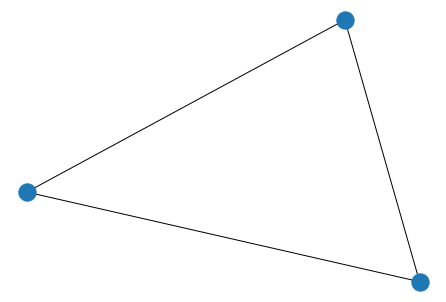

In [176]:
nx.draw(G)

In [177]:
#!pip install cirq
import cirq
import numpy as np
import math
import random
from scipy.optimize import minimize

In [178]:
# Define the list of qubits
num = len(set_edges)
depth = 3
rep = 1000
qubits = [cirq.GridQubit(0,i) for i in range(0, num)]

In [179]:
# define initialization
  #Preparing equal superpostions on all the qubits (putting Hadamard gate)
def initialization(qubits):
  for i in qubits:
    yield cirq.H.on(i)

In [180]:
#cost unitary
def cost_unitary(qubits, gamma):
  for i in set_edges:
    yield cirq.ZZPowGate(exponent=-1*gamma/math.pi).on(qubits[i.start_node], qubits[i.end_node])

In [181]:
# mixer unitary
def mixer_unitary(qubits, alpha):
  for i in range(0, len(qubits)):
    yield cirq.XPowGate(exponent=-1*alpha/math.pi).on(qubits[i])

In [185]:
#executes the circuit
def create_circuit(params):
  gamma = [params[0], params[2], params[4], params[6]]
  alpha = [params[1], params[3], params[5], params[7]]
  
  circuit = cirq.Circuit()
  circuit.append(initialization(qubits))
  for i in range(0, depth):
    circuit.append(cost_unitary(qubits, gamma[i]))
    circuit.append(mixer_unitary(qubits, alpha[i]))
  circuit.append(cirq.measure(*qubits, key='x'))
  print(circuit)
  simulator = cirq.Simulator()
  results = simulator.run(circuit, repetitions=rep)
  results = str(results)[2:].split(", ")
  new_res = []
  for i in range(0, rep):
    hold = []
    for j in range(0, num):
      hold.append(int(results[j][i]))
    new_res.append(hold)
  return new_res

In [186]:
# defines the cost function
def cost_function(params):
  av = create_circuit(params)
  total_cost = 0
  for i in range(0, len(av)):
    for j in set_edges:
      #the weights are added here
      # The cost would them be:
      # total_cost += 0.5()
      total_cost +=(0.5*(((1-av[i][j.start_node])*(1-av[i][j.end_node]))-1))*j.weight
  totals_cost = float(total_cost)/rep
  print("cost: " + str(total_cost))
  return total_cost

                                       ┌────────────────┐                                   ┌──────────────┐                                    ┌────────────────┐
(0, 0): ───H───ZZ───────────────────────ZZ──────────────────X^0.035───ZZ─────────────────────ZZ────────────────X^0.56───ZZ───────────────────────ZZ──────────────────X^0.411───M('x')───
               │                        │                             │                      │                          │                        │                             │
(0, 1): ───H───ZZ^-0.051───ZZ───────────┼────────X^0.035──────────────ZZ^0.939───ZZ──────────┼───────X^0.56─────────────ZZ^-0.137───ZZ───────────┼────────X^0.411──────────────M────────
                           │            │                                        │           │                                      │            │                             │
(0, 2): ───H───────────────ZZ^-0.051────ZZ^-0.051───────────X^0.035──────────────ZZ^0.939────ZZ^0.939──────────X^

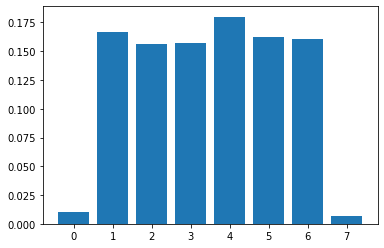

In [187]:
# Defines the optimization method

init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})
#print(out)

optimal_params = out['x']
f = create_circuit(optimal_params)

# Creates visualization of the optimal state

nums = []
freq = []

for i in range(0, len(f)):
    number = 0
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq]

print(nums)
print(freq)

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)

plt.bar(x, y)
plt.show()